In [1]:
# Update all data by scraping data
import downloader

try:
    downloader.update_market_cap()
except Exception as e:
    print(e)
    pass
try:
    downloader.update_coins()
except Exception as e:
    print(e)
    pass

Updating market cap...
Data is already up to date!

Updating coins...
DASH data already up to date!
TRX data already up to date!
LTC data already up to date!
ETH data already up to date!
ADA data already up to date!
IOTA data already up to date!
BTC data already up to date!
BCH data already up to date!
XEM data already up to date!
XLM data already up to date!
XMR data already up to date!
XRP data already up to date!
All downloads finished!



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

%matplotlib notebook

#### Load data
Import price data from csv files and add them to a list 

In [3]:
# Load all data from folder
import os

# Location of files
folder = '../price/'
tail = '.csv'
filenames = os.listdir(folder)
    
# Get the supplied coin name
coins = list(map(lambda x: re.sub(tail, '', x).upper(), filenames))

# Load data
df_list = []
for filename in filenames:
    df_list.append(pd.read_csv(folder + filename, delimiter='\t', index_col='Date', parse_dates=True))
    # input(filename + ' loaded.\nEnter to proceed')    # Debug for file read errors.


# Clear up each list
for index, df in enumerate(df_list):
    # Drop all columns except Date and Market Cap 
    df = df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
    # Convert Date column datatype to Date
    #df.index = pd.to_datetime(df.index)    
    
    # Convert Market Cap column datatype to numeric
    df['Market Cap'] = df['Market Cap'].str.replace(',', '')    # Remove commas
    df = df[df['Market Cap'].str.contains('-') == False]        # Delete missing data
    df['Market Cap'] = pd.to_numeric(df['Market Cap'])
    
    # Replace previous dataframe
    df_list[index] = df 
    

In [4]:
# Print df info
for index, df in enumerate(df_list):
    print('[' + str(index) + '] Ticker: ' + coins[index])
    df.info()
    print('--'*25)
    print(df.head())
    print('><'*25)

[0] Ticker: ADA
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98 entries, 2018-01-08 to 2017-10-03
Data columns (total 1 columns):
Market Cap    98 non-null int64
dtypes: int64(1)
memory usage: 1.5 KB
--------------------------------------------------
             Market Cap
Date                   
2018-01-08  25909700000
2018-01-07  26553200000
2018-01-06  25849300000
2018-01-05  30364400000
2018-01-04  28364900000
><><><><><><><><><><><><><><><><><><><><><><><><><
[1] Ticker: BCH
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 2018-01-08 to 2017-08-02
Data columns (total 1 columns):
Market Cap    160 non-null int64
dtypes: int64(1)
memory usage: 2.5 KB
--------------------------------------------------
             Market Cap
Date                   
2018-01-08  47091600000
2018-01-07  47054000000
2018-01-06  43653200000
2018-01-05  40557600000
2018-01-04  44069100000
><><><><><><><><><><><><><><><><><><><><><><><><><
[2] Ticker: BTC
<class 'pandas.core.frame.

In [5]:
# Load total market cap data
market_cap_df = pd.read_csv('../data/total_market_cap.csv', index_col='Date', parse_dates=True)
market_cap_df.head()

,Total Market Cap
Date,
2013-04-28,1596170359
2013-05-05,1341783003
2013-05-12,1367920068
2013-05-19,1448321940
2013-05-26,1548982054


Combine all coin dataframes to one single dataframe. The new dataframe is then resampled into weekly mean to fit the market cap data. To better visualize it's relation to benford's law the dataframe is then converted into percentage of total market cap.

In [6]:
len_list = [len(df) for df in df_list]
coin_index = len_list.index(max(len_list))    # Find index of coin with oldest data

# Create new data frame with coins as columns
cc_df = pd.DataFrame([], columns=coins, index=df_list[coin_index].index)
for i in range(0, len(len_list)):
    cc_df[coins[i]] = df_list[i]['Market Cap']
    
cc_df.head()

,ADA,BCH,BTC,DASH,ETH,IOTA,LTC,TRX,XEM,XLM,XMR,XRP
Date,,,,,,,,,,,,
2018-01-08,2.590970e+10,4.709160e+10,276612000000,1.001620e+10,1.121640e+11,1.131450e+10,15726800000,1.349120e+10,1.645400e+10,1.244210e+10,7.139010e+09,1.303020e+11
2018-01-07,2.655320e+10,4.705400e+10,294222000000,9.881510e+09,1.009810e+11,1.096830e+10,16178100000,1.141900e+10,1.489880e+10,1.268840e+10,7.103000e+09,1.198190e+11
2018-01-06,2.584930e+10,4.365320e+10,293091000000,9.026110e+09,9.632650e+10,1.043690e+10,13645300000,1.476040e+10,1.421670e+10,1.185400e+10,5.999260e+09,1.170330e+11
2018-01-05,3.036440e+10,4.055760e+10,259748000000,9.527170e+09,9.442390e+10,1.128660e+10,13164800000,1.377950e+10,1.519560e+10,1.321940e+10,6.262550e+09,1.278700e+11
2018-01-04,2.836490e+10,4.406910e+10,256250000000,9.151080e+09,9.304940e+10,1.146640e+10,13403400000,6.240820e+09,1.652030e+10,1.595360e+10,6.448110e+09,1.207630e+11


In [7]:
# Group by group_period as 7D, since market cap data points set at weekly
group_period = '7D'
cc_df = cc_df.resample(group_period).mean()
cc_df.head()

,ADA,BCH,BTC,DASH,ETH,IOTA,LTC,TRX,XEM,XLM,XMR,XRP
Date,,,,,,,,,,,,
2013-04-28,NaN,NaN,1.384919e+09,NaN,NaN,NaN,6.781151e+07,NaN,NaN,NaN,NaN,NaN
2013-05-05,NaN,NaN,1.262736e+09,NaN,NaN,NaN,5.974981e+07,NaN,NaN,NaN,NaN,NaN
2013-05-12,NaN,NaN,1.300063e+09,NaN,NaN,NaN,5.482550e+07,NaN,NaN,NaN,NaN,NaN
2013-05-19,NaN,NaN,1.395911e+09,NaN,NaN,NaN,5.704303e+07,NaN,NaN,NaN,NaN,NaN
2013-05-26,NaN,NaN,1.464011e+09,NaN,NaN,NaN,5.554451e+07,NaN,NaN,NaN,NaN,NaN


In [8]:
# Create ccp with percentage of total market cap
ccp_df = cc_df[coins].div(market_cap_df['Total Market Cap'], axis=0)
ccp_df = ccp_df[::-1]    # Reverse order of df
ccp_df.head()

,ADA,BCH,BTC,DASH,ETH,IOTA,LTC,TRX,XEM,XLM,XMR,XRP
Date,,,,,,,,,,,,
2018-01-07,0.031896,0.057238,0.347051,0.012097,0.129586,0.013547,0.019397,0.015145,0.019062,0.015279,0.008659,0.152066
2017-12-31,0.039647,0.074350,0.434708,0.015312,0.146262,0.018648,0.022744,0.012150,0.020765,0.017985,0.010180,0.180424
2017-12-24,0.052423,0.109015,0.274370,0.018376,0.273070,0.022977,0.049785,0.004832,0.016601,0.007995,0.013713,0.068307
2017-12-17,0.020938,0.076287,0.494514,0.016296,0.125222,0.020778,0.029391,0.004795,0.012927,0.007698,0.010045,0.057782
2017-12-10,0.010283,0.070250,0.722664,0.016856,0.149556,0.030611,0.034686,0.001813,0.012045,0.007308,0.011755,0.046163


Barplot on each coin's individual coin market cap as percentage of total market cap.

In [9]:
# Function to add percentage text on top of each bar in a barplot
def add_bar_percentage(ax):
    for r in ax.patches:
        height = r.get_height()
        ax.text(r.get_x()+r.get_width()/2.,    # x-pos of text
                height + 0.01,                 # y-pos of text
                '{:3.1f}%'.format(height*100), # text string
                ha="center") 

In [10]:
# Gather benford's distribution percentages
num_benfords = 10
benfords = [np.log10(1+1/i) for i in range(1, num_benfords + 1)]
x_ben = [x for x in range(0, num_benfords)]

<IPython.core.display.Javascript object>


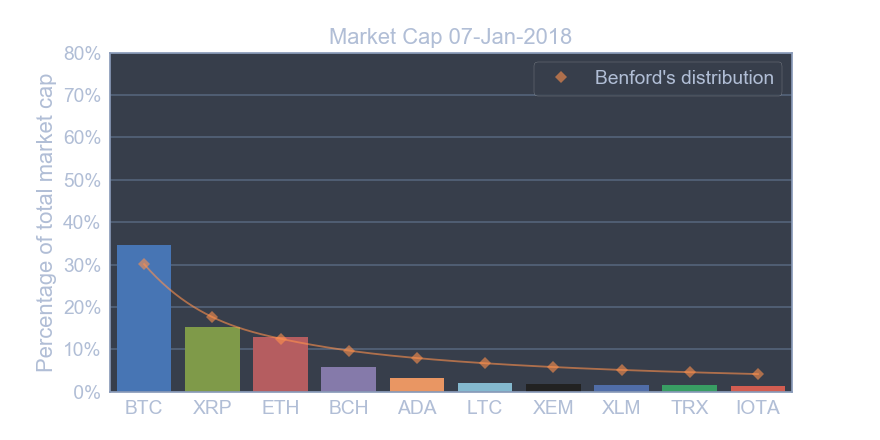

C:\IntelPython3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


In [11]:
# Plot data for Dec 2017
from matplotlib.dates import *

row = 0    # Data row to plot
row_data = ccp_df.iloc[row]
row_date = row_data.name.strftime('%d-%b-%Y')
sorted_ = row_data.sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(sorted_.index.values[:10], sorted_[:10], ax=ax)

ax.set_ylim(0, 0.8) # Adjust ylimits

# Set percentage ticks on yaxis
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
ax.set_axisbelow(True)
ax.autoscale_view()

# Add percentage text ontop of the bars
#add_bar_percentage(ax) 

## Plot benford's diagram
# Plot reference points for benford's diagram
ben, = plt.plot(x_ben, benfords, 'yD', alpha=0.6, zorder=2)
plt.legend([ben], ['Benford\'s distribution'])

# Create smooth interlopation of benfords distr
from scipy.interpolate import spline
x_smooth = np.linspace(0, 9, 300)
benfords_smooth = spline(x_ben, benfords, x_smooth)
# Plot smoothed benfords curve
plt.plot(x_smooth, benfords_smooth, 'y', alpha=0.6)

plt.title('Market Cap ' + row_date)
plt.ylabel('Percentage of total market cap')
#plt.savefig(str('mrktcap_' + row_data.name.strftime('%Y%m%d')))

<IPython.core.display.Javascript object>


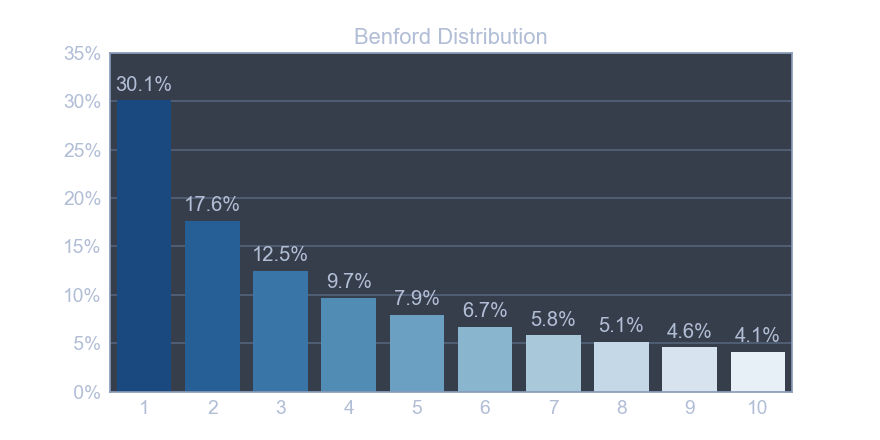

In [12]:
# Plot Benford's law as barplot
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot([x for x in range(1, num_benfords + 1)], benfords, palette='Blues_r')

add_bar_percentage(ax)
    
# Change y limits and display as percentages
ax.set_ylim(0, 0.35)  
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
ax.set_axisbelow(True)
ax.autoscale_view()

plt.title('Benford Distribution')
plt.show()